In [ ]:
#Code to run TICA docking for protein-ligand md on backbone positions

In [1]:
import pyemma
import glob
import numpy as np
import pyemma.plots as mplt
%pylab inline
import mdtraj as md
import pyemma.coordinates as coor
 
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res
 
def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

Populating the interactive namespace from numpy and matplotlib


In [2]:

trajfile = []
for i in range(1,6):
    path = '/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/joined_holo_md_'+str(i)+'.nc'
    trajfile.append(path)
print(trajfile)

#assigns the features, which in this case is backbone atom positions
feat = coor.featurizer('/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/holo_top.h5')
feat.add_selection(feat.select_Backbone())
print(feat.describe()[:13])

#defining the trajs and features without loading into memory
inp = coor.source(trajfile, feat)
print(inp)
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())


['/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/joined_holo_md_1.nc', '/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/joined_holo_md_2.nc', '/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/joined_holo_md_3.nc', '/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/joined_holo_md_4.nc', '/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/joined_holo_md_5.nc']
['ATOM:ACE 0 C 4 x', 'ATOM:ACE 0 C 4 y', 'ATOM:ACE 0 C 4 z', 'ATOM:ILE 1 N 6 x', 'ATOM:ILE 1 N 6 y', 'ATOM:ILE 1 N 6 z', 'ATOM:ILE 1 CA 8 x', 'ATOM:ILE 1 CA 8 y', 'ATOM:ILE 1 CA 8 z', 'ATOM:ILE 1 C 23 x', 'ATOM:ILE 1 C 23 y', 'ATOM:ILE 1 C 23 z', 'ATOM:LEU 2 N 25 x']


trajectory length =  100000
number of dimension =  1962


In [3]:
lag = 1000
tica_obj = coor.tica(inp, lag = lag, var_cutoff = 0.95, kinetic_map = False)
# here we get the data that has been projected onto the first 2 IC's. It's a list, because we could generally
# have a list of trajectories, so we just get the first element.

Y = tica_obj.get_output()

print('Mean values: ', np.mean(Y, axis=0))
print('Variances:   ', np.var(Y, axis=0))
#print(-lag/np.log(tica_obj.eigenvalues[:5]))

#making clusters from kmeans
cl = coor.cluster_kmeans(data = Y,k = 10, max_iter = 5000)


Mean values:  [[-3.4227371e-04 -2.8721095e-04 -2.3609400e-04 ... -4.9913019e-01
  -5.7640761e-01 -6.8762940e-01]
 [-4.4440030e-04 -9.6857548e-05 -1.2851119e-03 ... -5.2979887e-01
  -2.9238120e-01 -3.0056137e-01]
 [-5.1376817e-04  4.5938493e-04 -1.3916374e-03 ... -2.8078449e-01
  -4.4117171e-01 -5.8463681e-01]
 ...
 [-1.7137527e-04 -6.2127115e-04  6.8403484e-04 ... -3.0029908e-01
  -4.1871373e-02 -1.0386848e+00]
 [ 2.0804405e-04 -8.1822870e-04  2.5590658e-04 ...  5.1182663e-01
  -6.1635929e-01 -1.2731533e-01]
 [ 2.1238327e-04 -7.9493521e-04 -4.5123100e-04 ...  4.2708960e-01
   7.0129299e-01 -2.7963343e-01]]
Variances:    [[0.9999774  1.0004526  1.0019133  ... 0.8247145  2.3105512  1.2161582 ]
 [0.99998796 1.0003464  1.0014204  ... 0.11391944 0.9755114  1.5788115 ]
 [1.0002687  0.99964046 1.0021738  ... 0.678862   0.32439923 0.9328392 ]
 ...
 [1.0010611  1.0004741  0.99615943 ... 1.0243825  0.04858894 1.1968462 ]
 [0.9999771  1.0013666  1.0016038  ... 2.186652   0.9403952  0.9673139 ]
 [

In [4]:
# for later use we save the discretetrajectories (dtrajs) and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]
 
print(dtrajs)
print(np.size(dtrajs))


[array([2, 2, 3, ..., 3, 3, 3], dtype=int32), array([4, 4, 4, ..., 4, 4, 4], dtype=int32), array([8, 8, 8, ..., 5, 5, 5], dtype=int32), array([9, 9, 9, ..., 9, 9, 9], dtype=int32), array([7, 7, 7, ..., 6, 6, 6], dtype=int32)]
500000


In [5]:
cl.converged

True

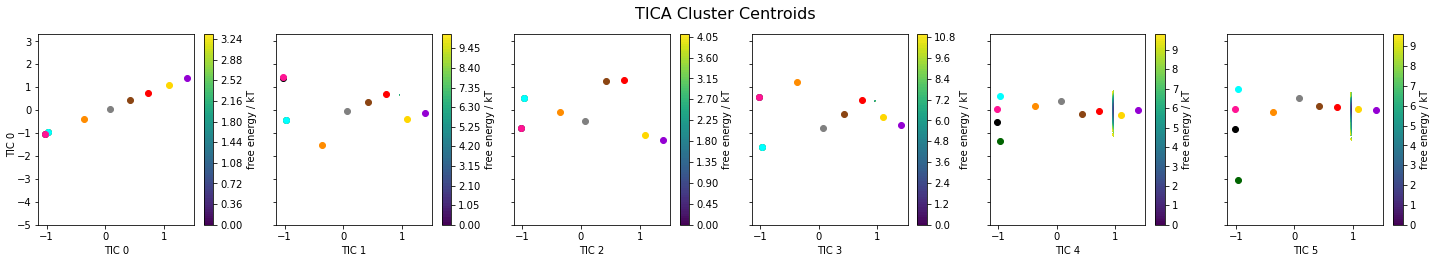

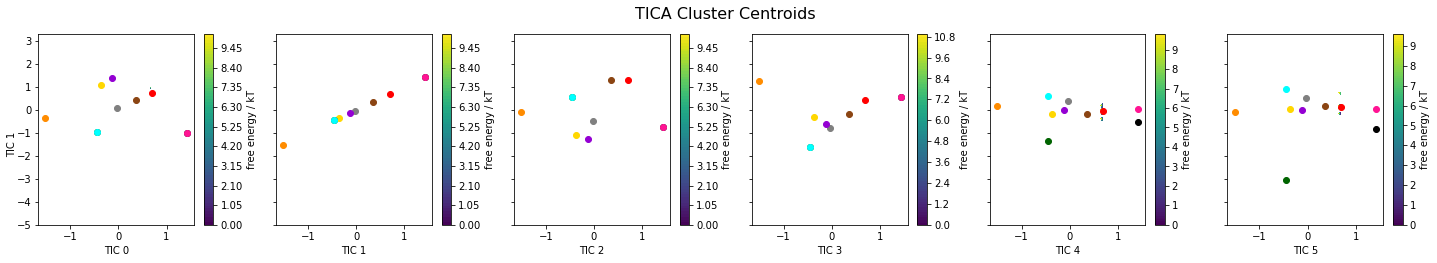

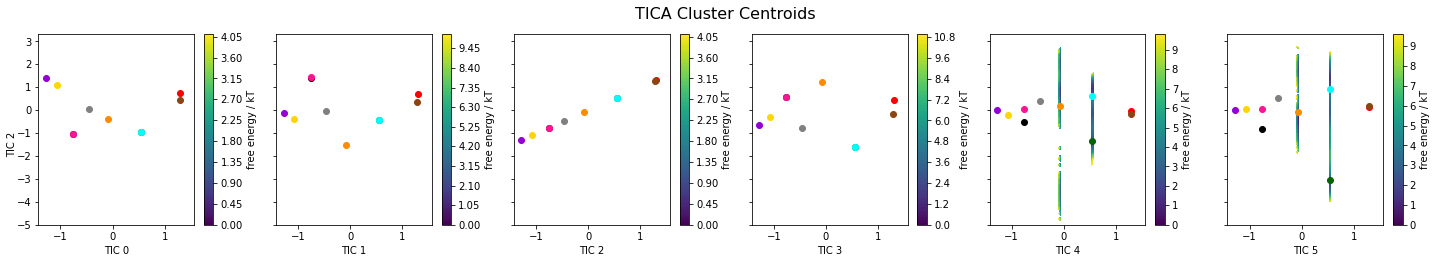

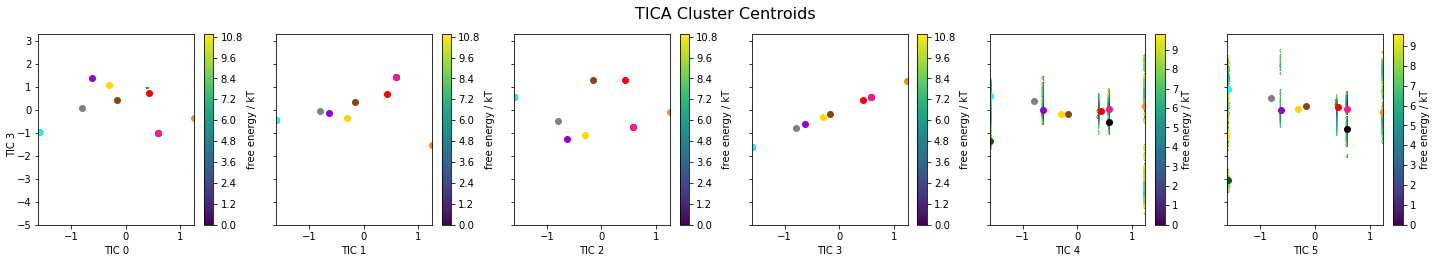

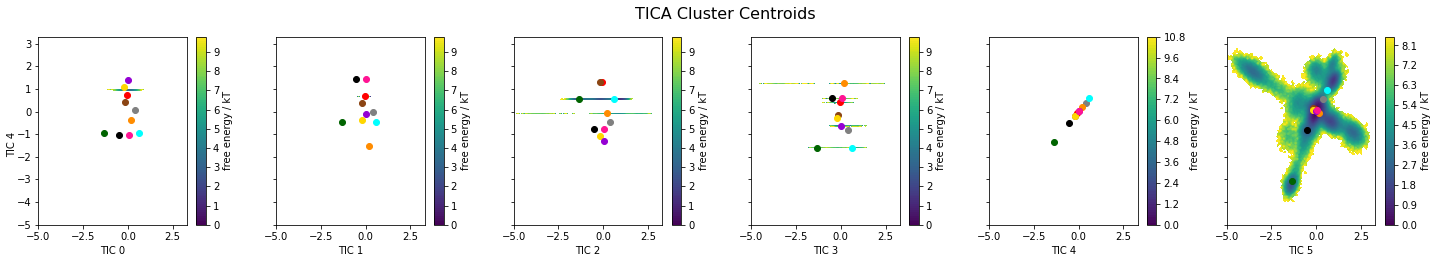

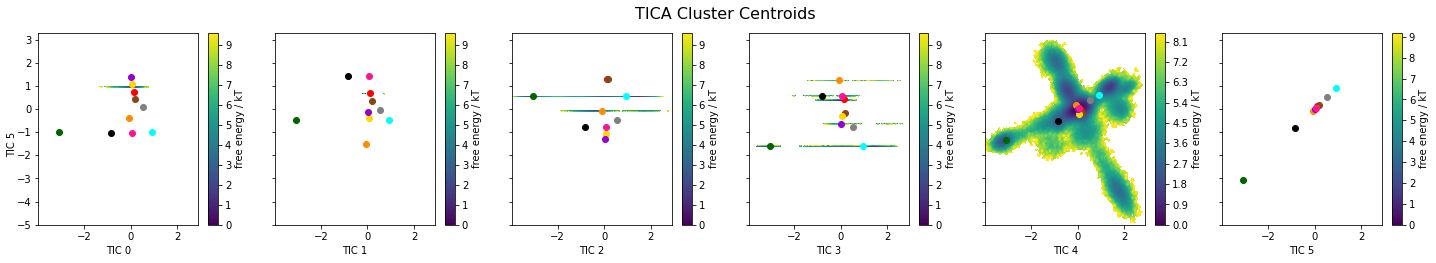

In [6]:
#plotting the free energy in subplots for tics 0-5

for s in range(6):
    fig, ax = plt.subplots(1, 6, sharex='col', sharey='row', figsize = (20,3.4)) #creating 1x6 subplot grid
    
    for w in range(6):
        mplt.plot_free_energy(np.vstack(Y)[:,s], np.vstack(Y)[:,w], ax = ax[w], cmap = 'viridis')#, cbar = False, cbar_label = None)
        cc_x = cl.clustercenters[:,s]
        cc_y = cl.clustercenters[:,w]
        #ax[w].plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='red')
        colors = ['black','gray','red','saddlebrown','darkorange','gold','darkgreen','aqua','darkviolet','deeppink']
        for i in range(10):
            ax[w].scatter(cc_x[i], cc_y[i], color = colors[i])
    
    for a in range(6):
        ax[a].set(xlabel = ('TIC '+str(a)))
        
    fig.text(0.001, 0.5, 'TIC '+str(s), va = 'center', rotation='vertical')
    
    fig.suptitle('TICA Cluster Centroids',fontsize = 16, y=1.06)
    fig.tight_layout()

    plt.savefig('/home/jegan/Clustering_methods/TICA/figs/bkbnpos_holo/TICA_holo_FE_TIC'+str(s)+'.png', bbox_inches = 'tight')


In [11]:
#This tells us how much each feature contributes to each TIC
tica_obj.feature_TIC_correlation

array([[ 8.25074155e-01, -5.12416893e-01,  3.46861618e-02, ...,
         3.26248648e-04, -7.45578079e-04,  7.35942977e-04],
       [ 7.04590991e-01, -3.86736414e-01,  4.63913324e-01, ...,
        -5.30214948e-04,  1.52315475e-03, -1.29761757e-03],
       [ 7.41975813e-01,  6.47023504e-01, -1.47652229e-01, ...,
         1.45254151e-03, -9.76808145e-04, -9.21294653e-04],
       ...,
       [ 6.03397311e-01, -6.72974489e-01, -4.25881194e-01, ...,
         9.74323854e-05, -9.81987997e-04,  7.71861416e-04],
       [ 7.80948868e-01, -1.38469996e-01,  3.98873801e-01, ...,
        -1.08238184e-03,  4.47784363e-04, -1.43348071e-03],
       [ 8.49198923e-01,  3.50858896e-01,  2.47491255e-01, ...,
        -3.77497058e-04,  2.38155478e-05,  4.45946047e-04]])

In [9]:
#This tells us the number of TICs TICA produces to retain the variance we want, which is .95
tica_obj.cumvar

array([0.00122616, 0.00245121, 0.00367618, ..., 1.        , 1.        ,
       1.        ])

In [7]:
#This prints the discrete trajectories we saved out before, then saves out the percent of frames in each cluster
print(dtrajs)
print(dtrajs[0])

with open('/home/jegan/Clustering_methods/TICA/clusters_holo.txt', 'w') as newfile:
    numb = []
    for i in range(10):
        frames = []
        for k in dtrajs:
            for p in k:
                if p == i:
                    frames.append(p)

        print(len(frames))
        numb.append(len(frames))
    
    newfile.write('Percent of frames per TICA bkbnpos holo cluster:\n')
    tot = 0
    index = 0
    for j in numb:
        tot += j
        percent = (j/450000)*100
        num = str(percent)
        newfile.write('Cluster '+ str(index)+' = '+num+' %\n')
        index += 1
    print(tot)


[array([2, 2, 3, ..., 3, 3, 3], dtype=int32), array([4, 4, 4, ..., 4, 4, 4], dtype=int32), array([8, 8, 8, ..., 5, 5, 5], dtype=int32), array([9, 9, 9, ..., 9, 9, 9], dtype=int32), array([7, 7, 7, ..., 6, 6, 6], dtype=int32)]
[2 2 3 ... 3 3 3]
8428
4741
75466
47266
87844
60648
23540
61118
47775
83174
500000


In [12]:
#Extracting Centroids

avg = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

indices = {}
for i in range(len(Y)):
    for k in range(len(Y[i])):
        c = cl.clustercenters[cl.dtrajs[i][k]]
        v = Y[i][k]
        newavg = np.linalg.norm(c-v)
        if avg[cl.dtrajs[i][k]] > newavg:
            avg[cl.dtrajs[i][k]] = newavg
            indices[cl.dtrajs[i][k]] = [i, k]
            
            
pdb0 = md.load('/home/jegan/final_centroids/XTAL/XTAL_0.pdb')

z = 0
for key in indices:
        z = z + 1
        index = indices[key][1]*(1 + indices[key][0])
        print(index)
        
        cen = md.load_frame('/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/entire_holo_md.nc', index, top = '/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/holo_top.h5')
        pdb = cen.superpose(pdb0,0)
        
        pdb.save_pdb('/home/jegan/Clustering_methods/TICA/TICA_holo_centroids/TICA_%s.pdb' % (z-1))

168892
347900
262008
154728
126285
270240
125172
342160
49900
499135
